In [1]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2

import typing as t

from matplotlib import pyplot
import matplotlib.patches as patches

import numpy
from numpy.typing import NDArray, ArrayLike

from phaser.utils.num import to_numpy, abs2, fft2, ifft2, get_scipy_module

import cupy

In [3]:
from phaser.state import ReconsState

xp = cupy

state = ReconsState.read_hdf5("../srtio3_exp/iter150.h5")
# hack
#object.__setattr__(state.object.sampling, 'region_max', -state.object.sampling.region_min)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../srtio3_exp/iter150.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

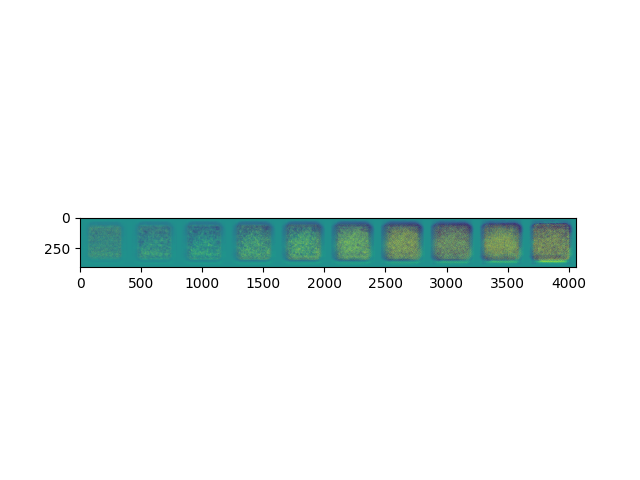

In [80]:
def _plot_object_stack(ax, obj):
    ax.imshow(numpy.concatenate(numpy.unstack(numpy.angle(obj), axis=0), axis=1), vmin=-0.2, vmax=0.2)

fig, ax = pyplot.subplots()

_plot_object_stack(ax, state.object.data)

In [95]:
obj = xp.array(state.object.data)
scipy = get_scipy_module(obj)

layer_spacing = 20.
sigma = 50.

r = int(numpy.ceil(sigma / layer_spacing * 2. / 2.))
n = 2*r + 1

zs = (xp.arange(0, n) - (n-1)//2) * layer_spacing
kernel = xp.exp(-(zs / sigma)**2 / 2.) #.reshape((n, 1, 1))
kernel /= xp.sum(kernel)

#kernel = numpy.array([1., 1., 1., 1., 1.]) / 5.

#new_obj = xp.exp(scipy.signal.oaconvolve(xp.pad(xp.log(obj), pad_width=((r, r), (0, 0), (0, 0)), mode='edge'), kernel, axes=0, mode='valid'))
new_obj = xp.exp(scipy.ndimage.convolve1d(xp.log(obj), kernel, axis=0, mode='nearest'))

weight = 0.9
new_obj = new_obj * weight + obj * (1 - weight)

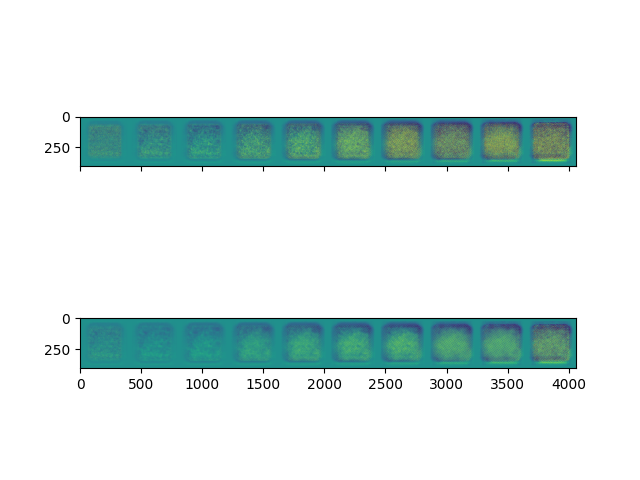

In [93]:
fig, (ax1, ax2) = pyplot.subplots(nrows=2, sharex=True, sharey=True)

_plot_object_stack(ax1, to_numpy(obj))
_plot_object_stack(ax2, to_numpy(new_obj))

In [2]:
from phaser.plan import ReconsPlan, ConventionalEnginePlan
from phaser.execute import initialize_reconstruction, prepare_for_engine, Observer

plan = ReconsPlan.from_yaml("../srtio3_exp.yaml")

class MyObserver(Observer):
    def update_group(self, state, force: bool = False):
        super().update_group(state)

    def update_iteration(self, state, i: int, n: int, error: t.Optional[float] = None):
        super().update_iteration(state, i, n, error=error)

xp = cupy
dtype = numpy.float32
observer = MyObserver()
(patterns, state) = initialize_reconstruction(plan, xp, observer)

INFO:root:Executing plan...
INFO:root:dtype: <class 'numpy.float32'> array backend: cupy
INFO:root:dtype: <class 'numpy.float32'> array backend: cupy
INFO:root:Initializing probe...
INFO:phaser.hooks.probe:Making probe, conv_angle 25.0 mrad, defocus 150.0 A
INFO:root:Initializing scan...
INFO:root:Initializing object...


Diffraction shift: [-0.04344037624972294, -0.09307902137299688]


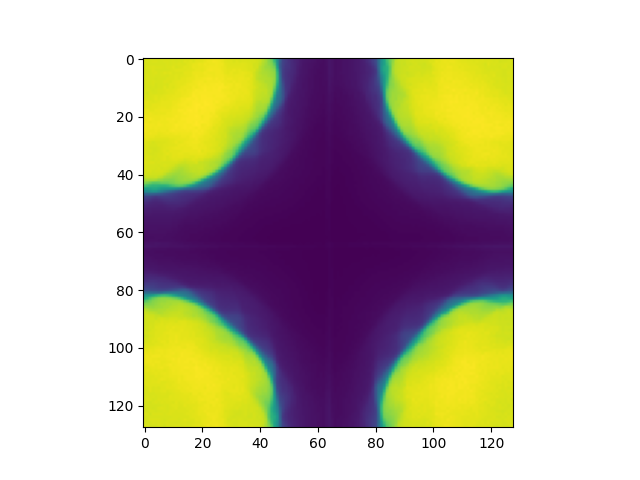

In [5]:
fig, ax = pyplot.subplots()

mean_pattern = xp.nanmean(xp.array(patterns.patterns), axis=range(patterns.patterns.ndim - 2))
ax.imshow(to_numpy(mean_pattern))

ky, kx = state.probe.sampling.recip_grid(xp=xp)
yy, xx = state.probe.sampling.real_grid(xp=xp)

ky_shift = xp.nansum(ky * mean_pattern) / xp.nansum(mean_pattern)
kx_shift = xp.nansum(kx * mean_pattern) / xp.nansum(mean_pattern)
print(f"Diffraction shift: [{kx_shift * state.probe.sampling.extent[1]}, {ky_shift * state.probe.sampling.extent[0]}]")

pyplot.show()

In [ ]:
from phaser.utils.optics import fourier_shift_filter
from phaser.utils.misc import create_sparse_groupings

grouping = 128

for group in create_sparse_groupings(patterns.patterns.shape[:-2]):
    patterns.patterns[*group] = fft2(ifft2(xp.array(patterns.patterns[*group])) * fourier_shift_filter(yy, xx, (ky_shift, kx_shift)))